## Loading


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import random
import numpy as np

file_path = "/mnt/c/Users/Charlotte/Nextcloud2/Uni/Masterarbeit/Fulltext screening/dataExtractionForm_v2.7_2025-12-06.xlsx"

df_DEF = pd.read_excel(file_path, sheet_name="DEF")

df_paper_list = pd.read_excel(file_path, sheet_name="Full cited-by list")


## Cleaning DEF

df_DEF = df_DEF.transpose()

# Get rid of row that contains notes
df_DEF = df_DEF.drop("Unnamed: 2")

# Make Questions column names
# new_columns = df_DEF.iloc[0].astype(str) + ' ' + df_DEF.iloc[1].astype(str)
new_columns = df_DEF.iloc[1].astype(str)

df_DEF = df_DEF.drop(df_DEF.index[[0, 1]]).reset_index(drop=True)
df_DEF.columns = new_columns


In [2]:
# Get only papers where a XAI method was applied

# Without duplicates (paper that apply several XAI methods only appear once)

df_xai_applied_no_dupl = df_DEF[
    (df_DEF["Do the authors apply a feature attribution method?"] == "yes")
].reset_index(drop=True)

# Merge papers info to DEF
df_xai_applied_no_dupl = pd.merge(
    df_xai_applied_no_dupl,
    df_paper_list[["EID", "Year", "Cited by", "citations_per_year"]],  
    left_on="Paper EID",
    right_on="EID",
    how="left"  
)

# With duplicates (paper that apply several XAI method

column_indicating_duplicate = "Is the column the second column belonging to a paper?  (Because more than one method was applied) "

df_xai_applied_with_dupl = df_DEF[
    (df_DEF["Do the authors apply a feature attribution method?"] == "yes") |
    (df_DEF[column_indicating_duplicate] == "yes")
].reset_index(drop=True)


In [3]:
column_names_series = pd.Series(df_xai_applied_with_dupl.columns)

In [4]:
columns_purpose = [
       'Model (in)validation', 
       'Data (in)validation',
       'Scientific discovery', 
       'Finding intervention targets',
       'Visually localizing lesions as part of the final tool', 
       'Vague explainability claims']

columns_feature_assumptions = [
       'Features “used” by the model',
       'Features statistically associated',
       'Features causally driving the target',
       'Features caused by the target',
       'Features being confounded',
       'Features acting as suppressors',
       'Features representing outliers or reflecting distribution shifts',
       'Salient image features, e.g. edges',
       'Other assumptions']

columns_consequences = [
       'Model rejection, refinement or retraining', 
       'Training data (and thus model) rejection',
       'Test data point rejection',
       'Data cleaning, denoising, artifact removal/mitigation etc.',
       'Independent replication due to validity concerns',
       '“Clearing” for subsequent use or next validation stage',
       'Followup-study to test the associational/causal role of identified features',
       'Prospective intervention on a feature to change/improve model output',
       'Prospective intervention on a feature to change/improve target variable in the real world',
       'Other consequences']



## PLOTS


### General


In [5]:
# Get the 'tab20' colormap
tab20_colors = plt.cm.tab20.colors

def create_frequency_bar_plot(title, series_to_plot, bin_chart = False):
    # Randomly select one color
    random_color = random.choice(tab20_colors)

    # Make sure label "yes" comes before "NR":
    if "yes" in series_to_plot.index:
        new_index = ['yes'] + [x for x in series_to_plot.index if x != 'yes']
        series_to_plot = series_to_plot.reindex(new_index)

    # Create plot values (for bar or line chart)
    if bin_chart == False:
        ax = series_to_plot.plot.bar(color=random_color)
    else: 
        ax = series_to_plot.hist(bins=20, color=random_color, rwidth=0.8)


    # Add axis labels and title
    plt.xlabel("")
    plt.ylabel('Number of Papers')
    plt.title(title)
    plt_title = plt.title(title)
    plt.setp(plt_title, wrap=True)
    plt.xticks(rotation=45, ha='right')

    # Customize the axis lines
    ax.spines['top'].set_visible(False)    # Hide top spine
    ax.spines['right'].set_visible(False)  # Hide right spine
    ax.spines['bottom'].set_color('lightgrey') # Set bottom (x-axis) to grey
    ax.spines['left'].set_visible(False)   # Hide left (y-axis)
    ax.tick_params(axis='x', colors='lightgrey')
    ax.tick_params(axis='y', colors='lightgrey')
    for label in ax.get_xticklabels():
        label.set_color('black')  # x-axis tick labels
    for label in ax.get_yticklabels():
        label.set_color('grey')  # x-axis tick labels

    # Add horizontal grid lines
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, which='major', linestyle='-', linewidth=0.5, color='lightgrey')
    ax.xaxis.grid(False)


    # Create plot file name from column name
    file_name = title.replace(" ", "_")
    file_name = file_name.replace("?", "")

    # Save the plot as an image file
    timestamp = datetime.now().strftime("%Y-%m-%d-%H%M")
    plt.savefig("DEF_stats/" + file_name + timestamp + ".png", format='png', dpi=200, bbox_inches='tight')


#### Stats over included and excluded papers


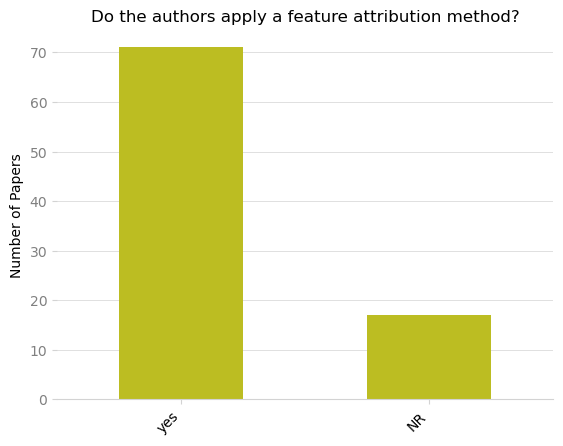

In [6]:
column_to_plot = "Do the authors apply a feature attribution method?"

create_frequency_bar_plot(column_to_plot, df_DEF[column_to_plot].value_counts())

#### Stats over included papers


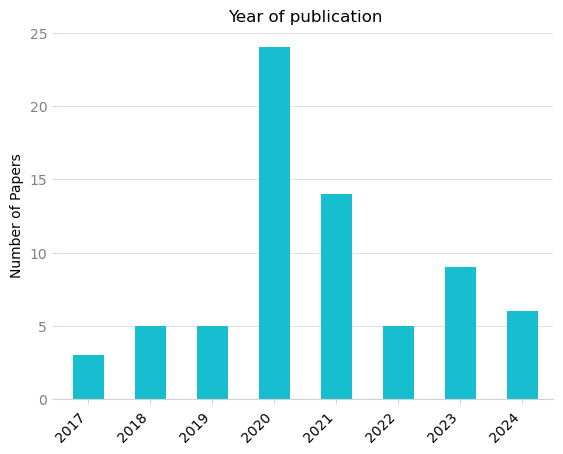

In [7]:
# Year of publication
column_to_plot = "Year"

# Convert values to int
df_xai_applied_no_dupl[column_to_plot] = df_xai_applied_no_dupl[column_to_plot].astype(int)

# Count the values and set right order
value_counts = df_xai_applied_no_dupl[column_to_plot].value_counts().sort_index()


create_frequency_bar_plot("Year of publication", value_counts)

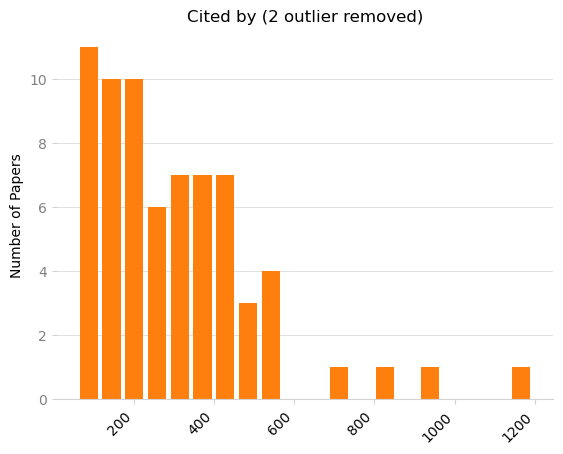

In [8]:
# Number of citations
column_to_plot = 'Cited by'

column_to_plot_no_outlier = df_xai_applied_no_dupl[column_to_plot][df_xai_applied_no_dupl[column_to_plot] <= 1500].copy()

create_frequency_bar_plot(column_to_plot + " (2 outlier removed)", column_to_plot_no_outlier, bin_chart = True)

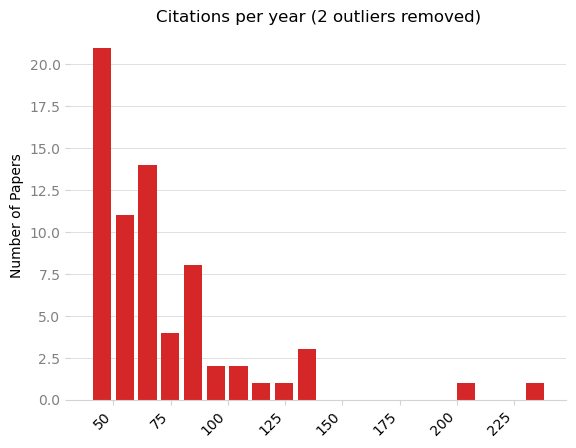

In [9]:
# Number of citations (average per year)

# Number of citations
column_to_plot = 'citations_per_year'

column_to_plot_no_outlier = df_xai_applied_no_dupl[column_to_plot][df_xai_applied_no_dupl[column_to_plot] <= 300].copy()

create_frequency_bar_plot("Citations per year (2 outliers removed)", column_to_plot_no_outlier, bin_chart = True)

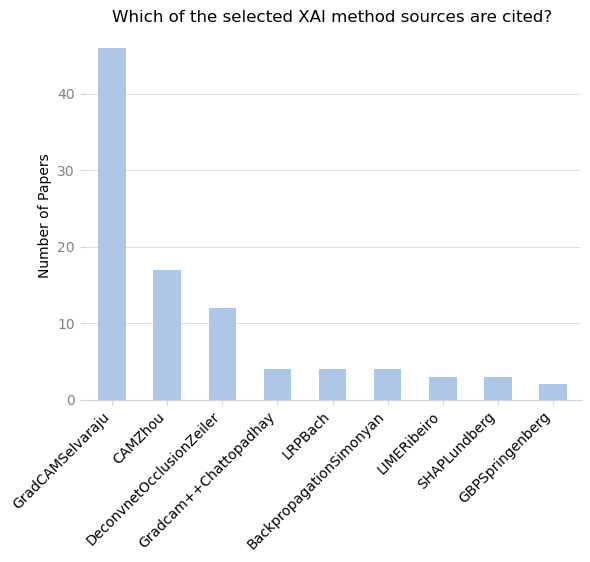

In [10]:
column_to_plot = "Which of the selected XAI method sources are cited?"

# Split the strings by comma and strip whitespace
split_values = df_xai_applied_no_dupl[column_to_plot].str.split(',').explode()

# Count the values
value_counts = split_values.str.strip().value_counts()

create_frequency_bar_plot(column_to_plot, value_counts)

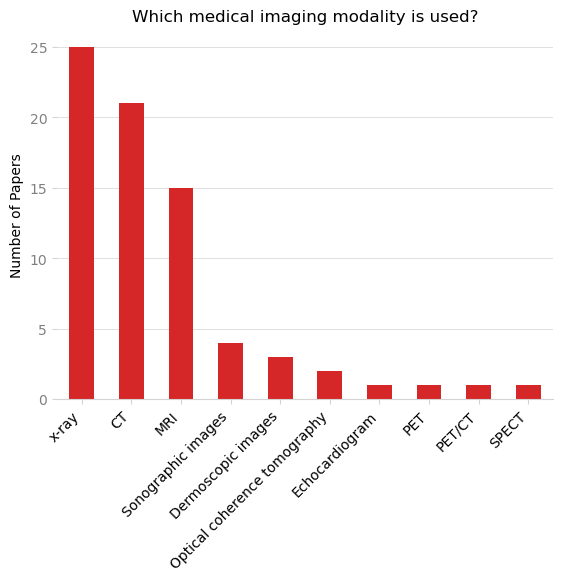

In [11]:
column_to_plot = "Which medical imaging modality is used?"

# Split the strings by comma and strip whitespace
split_values = df_xai_applied_no_dupl[column_to_plot].str.split(',').explode()

# Count the values
value_counts = split_values.str.strip().value_counts()

create_frequency_bar_plot(column_to_plot, value_counts)

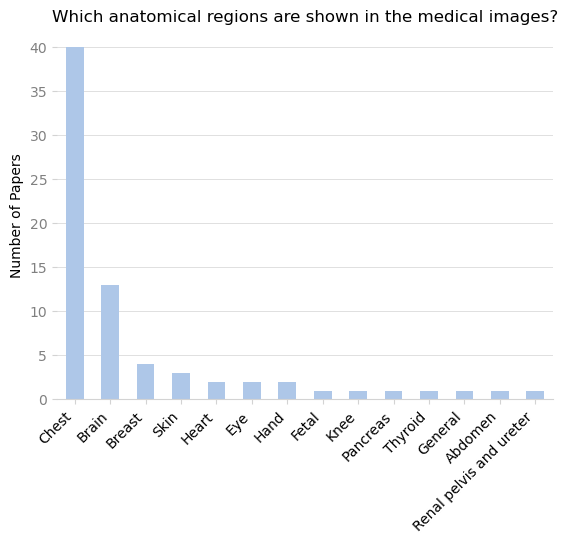

In [12]:
column_to_plot = "Which parts of the body are shown in the medical image?"

# Split the strings by comma and strip whitespace
split_values = df_xai_applied_no_dupl[column_to_plot].str.split(',').explode()

# Count the values
value_counts = split_values.str.strip().value_counts()

create_frequency_bar_plot("Which anatomical regions are shown in the medical images?", value_counts)

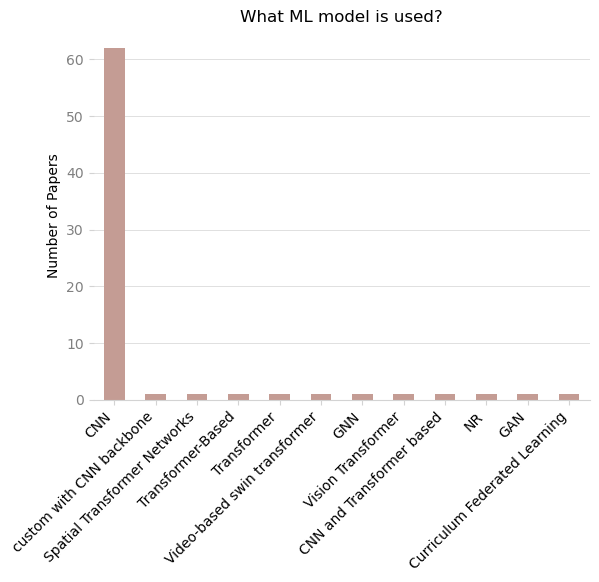

In [13]:
column_to_plot = "What ML model is used?"

# Split the strings by comma and strip whitespace
split_values = df_xai_applied_no_dupl[column_to_plot].str.split(',').explode()

# Count the values
value_counts = split_values.str.strip().value_counts()

create_frequency_bar_plot(column_to_plot, value_counts)

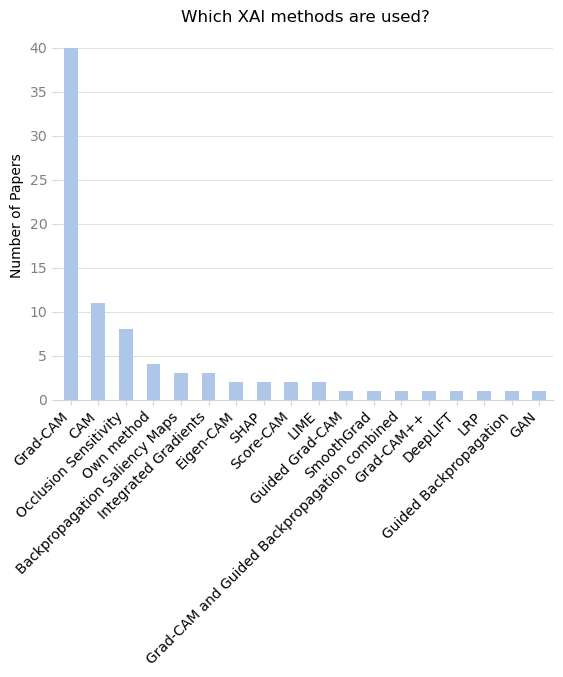

In [14]:
column_to_plot = "Which XAI methods are used?"

# Split the strings by comma and strip whitespace
split_values = df_xai_applied_with_dupl[column_to_plot].str.split(',').explode()

# Count the values
value_counts = split_values.str.strip().value_counts()

create_frequency_bar_plot(column_to_plot, value_counts)


### XAI Application presentation


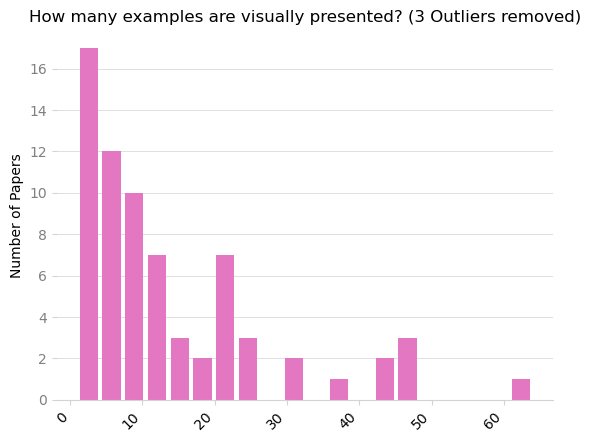

In [15]:
column_to_plot = 'How many examples are visually presented?'

column_to_plot_no_outlier = df_xai_applied_with_dupl[column_to_plot][df_xai_applied_with_dupl[column_to_plot] <= 100].copy()


create_frequency_bar_plot(column_to_plot + " (3 Outliers removed)", column_to_plot_no_outlier, bin_chart = True)

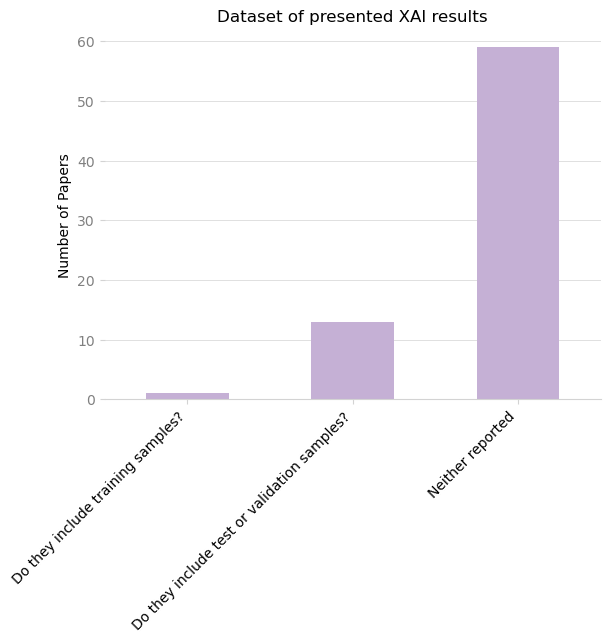

In [16]:
columns_to_plot = [
       'Do they include training samples?',
       'Do they include test or validation samples?',]

valid_counts = {}
for column in columns_to_plot:
      valid_counts[column] = df_xai_applied_with_dupl[column][df_xai_applied_with_dupl[column] == "yes"].count()

# Zähle die Fälle, in denen beide Spalten "NR" sind
both_nr_count = ((df_xai_applied_with_dupl[columns_to_plot[0]] == "NR") &
                 (df_xai_applied_with_dupl[columns_to_plot[1]] == "NR")).sum()
valid_counts["Neither reported"] = both_nr_count

# Erstelle den Balkenplot
valid_counts_df = pd.Series(valid_counts)

title = 'Dataset of presented XAI results'

create_frequency_bar_plot(title, valid_counts_df)




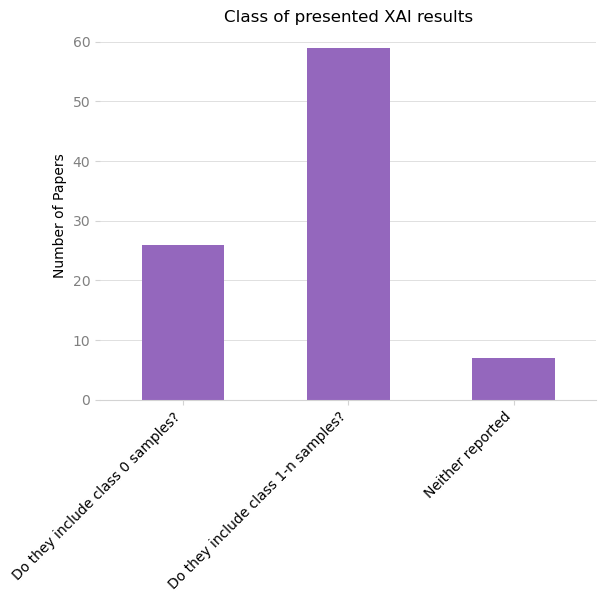

In [17]:
columns_to_plot = [
       'Do they include class 0 samples?',
       'Do they include class 1-n samples?']

valid_counts = {}
for column in columns_to_plot:
      valid_counts[column] = df_xai_applied_with_dupl[column][df_xai_applied_with_dupl[column] == "yes"].count()

# Zähle die Fälle, in denen beide Spalten "NR" sind
both_nr_count = ((df_xai_applied_with_dupl[columns_to_plot[0]] == "NR") &
                 (df_xai_applied_with_dupl[columns_to_plot[1]] == "NR")).sum()
valid_counts["Neither reported"] = both_nr_count

# Erstelle den Balkenplot
valid_counts_df = pd.Series(valid_counts)

title = 'Class of presented XAI results'

create_frequency_bar_plot(title, valid_counts_df)




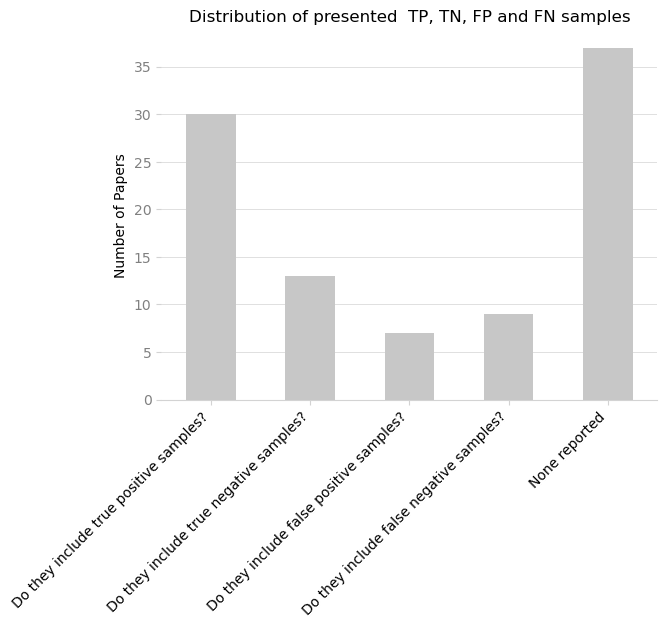

In [18]:
title = 'Distribution of presented  TP, TN, FP and FN samples'

columns_to_plot = [
       'Do they include true positive samples?',
       'Do they include true negative samples?',
       'Do they include false positive samples?',
       'Do they include false negative samples?',]

valid_counts = {}
for column in columns_to_plot:
      valid_counts[column] = df_xai_applied_with_dupl[column][df_xai_applied_with_dupl[column] == "yes"].count()

# Count papers where all cases are not reported
both_nr_count = ((df_xai_applied_with_dupl[columns_to_plot[0]] == "NR") &
                 (df_xai_applied_with_dupl[columns_to_plot[1]] == "NR") &
                 (df_xai_applied_with_dupl[columns_to_plot[2]] == "NR") &
                 (df_xai_applied_with_dupl[columns_to_plot[3]] == "NR")).sum()
valid_counts["None reported"] = both_nr_count
valid_counts_df = pd.Series(valid_counts)

create_frequency_bar_plot(title, valid_counts_df)

### Claims


In [19]:
# Add additional purpose as own column 
column = 'Additional interpretations'
new_column_name = 'Visually localizing lesions as part of the final tool'  # Name der neuen Spalte

# Neue Spalte erstellen: "yes", wenn der Eintrag exakt übereinstimmt, sonst NaN (oder z. B. "no")
df_xai_applied_with_dupl[new_column_name] = df_xai_applied_with_dupl[column].apply(
    lambda x: "yes" if x == "Visually localizing lesions as part of the final tool" else np.nan
)


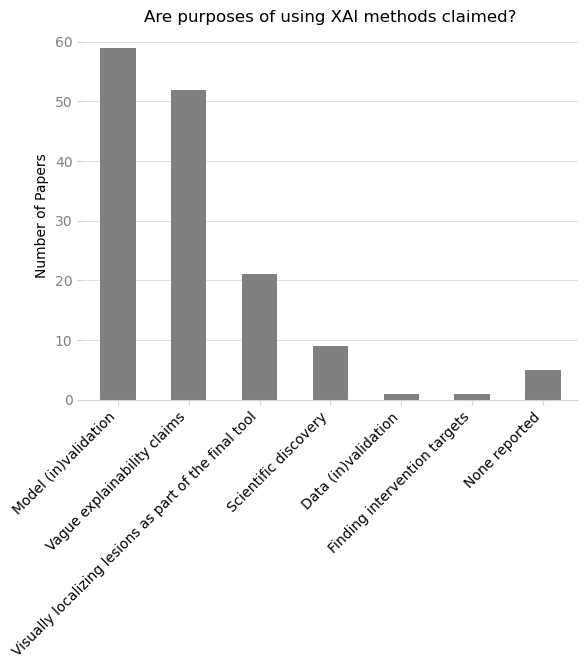

In [20]:
# E1 Purposes
title = 'Are purposes of using XAI methods claimed?'

valid_counts = {}
for column in columns_purpose:
      valid_counts[column] = df_xai_applied_with_dupl[column][(df_xai_applied_with_dupl[column] != 'NR') & (df_xai_applied_with_dupl[column] != 'N/A') & (~df_xai_applied_with_dupl[column].isna())].count()

# Erstelle den Balkenplot
valid_counts_df = pd.Series(valid_counts).sort_values(ascending=False)

both_nr_count = ((df_xai_applied_with_dupl[title] == "NR")).sum()
valid_counts_df["None reported"] = both_nr_count

create_frequency_bar_plot(title, valid_counts_df)

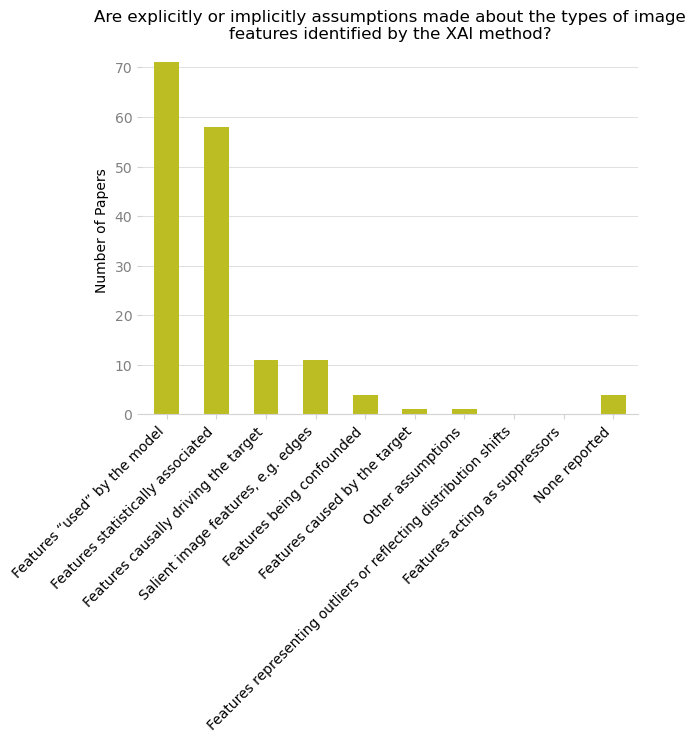

In [21]:
# E2 Feature assumptions
title = 'Are explicitly or implicitly assumptions made about the types of image features identified by the XAI method?'

valid_counts = {}
for column in columns_feature_assumptions:
      valid_counts[column] = df_xai_applied_with_dupl[column][(df_xai_applied_with_dupl[column] != 'NR') & (df_xai_applied_with_dupl[column] != 'N/A') & (~df_xai_applied_with_dupl[column].isna())].count()

# Erstelle den Balkenplot
valid_counts_df = pd.Series(valid_counts).sort_values(ascending=False)

both_nr_count = ((df_xai_applied_with_dupl[title] == "NR")).sum()
valid_counts_df["None reported"] = both_nr_count

create_frequency_bar_plot(title, valid_counts_df)

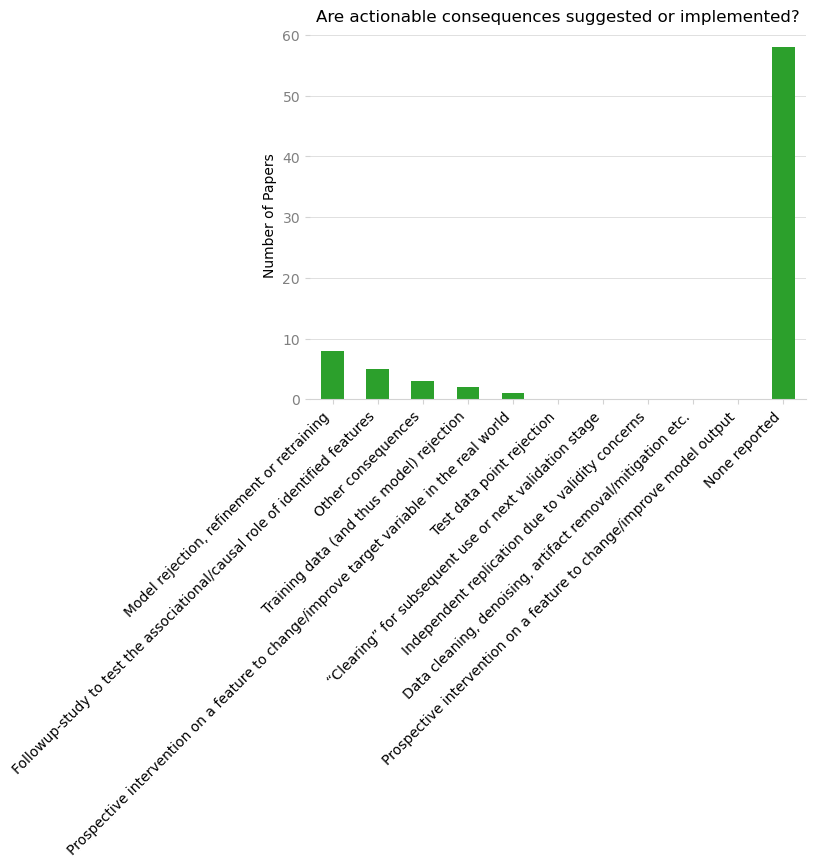

In [22]:
# E3 Consequences
title = 'Are actionable consequences suggested or implemented?'


valid_counts = {}
for column in columns_consequences:
      valid_counts[column] = df_xai_applied_with_dupl[column][(df_xai_applied_with_dupl[column] != 'NR') & (df_xai_applied_with_dupl[column] != 'N/A') & (~df_xai_applied_with_dupl[column].isna())].count()

# Erstelle den Balkenplot
valid_counts_df = pd.Series(valid_counts).sort_values(ascending=False)

both_nr_count = ((df_xai_applied_with_dupl[title] == "NR")).sum()
valid_counts_df["None reported"] = both_nr_count


create_frequency_bar_plot(title, valid_counts_df)

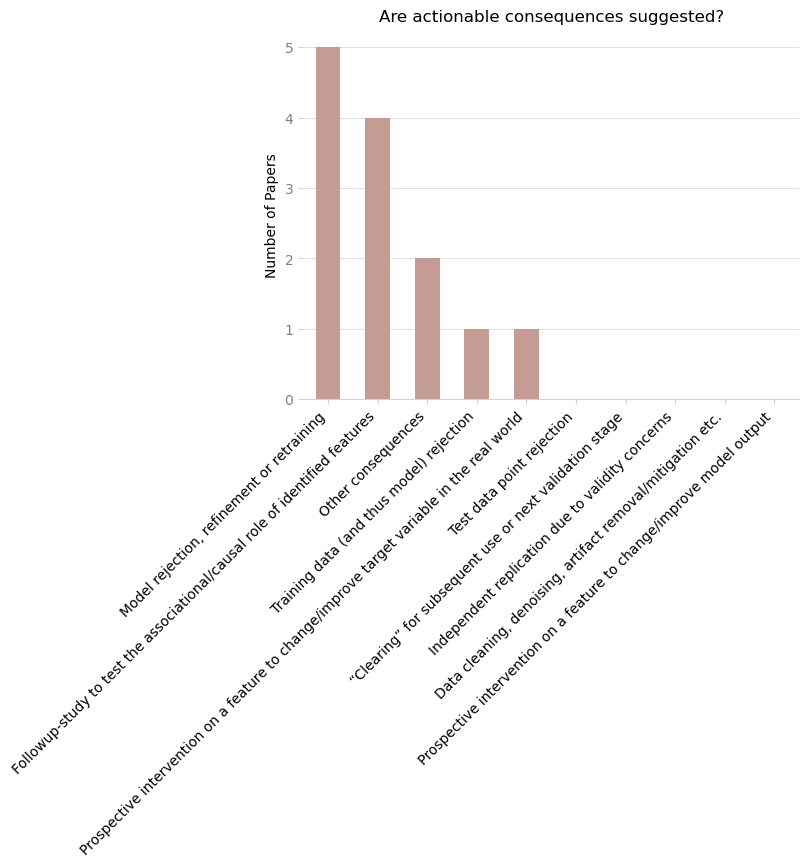

In [23]:
# E3 Consequences
title = 'Are actionable consequences suggested?'


valid_counts = {}
for column in columns_consequences:
      valid_counts[column] = df_xai_applied_with_dupl[column].str.startswith("Suggested", na=False).sum()

# Erstelle den Balkenplot
valid_counts = pd.Series(valid_counts).sort_values(ascending=False)

create_frequency_bar_plot(title, valid_counts)

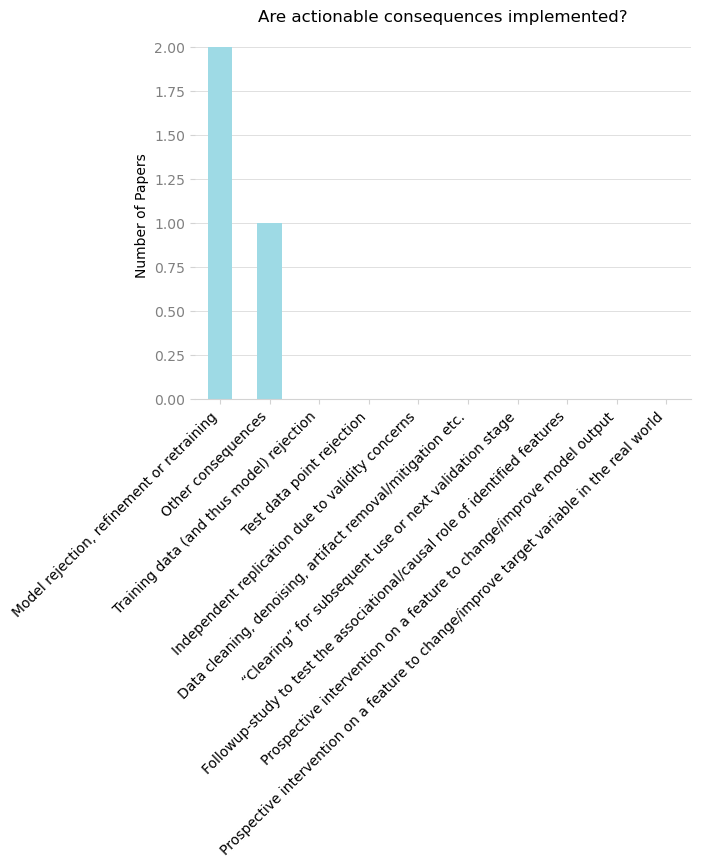

In [24]:
# E3 Consequences
title = 'Are actionable consequences implemented?'


valid_counts = {}
for column in columns_consequences:
      valid_counts[column] = df_xai_applied_with_dupl[column].str.startswith("Implemented", na=False).sum()


# Erstelle den Balkenplot
valid_counts = pd.Series(valid_counts).sort_values(ascending=False)

create_frequency_bar_plot(title, valid_counts)

### Analysing groups


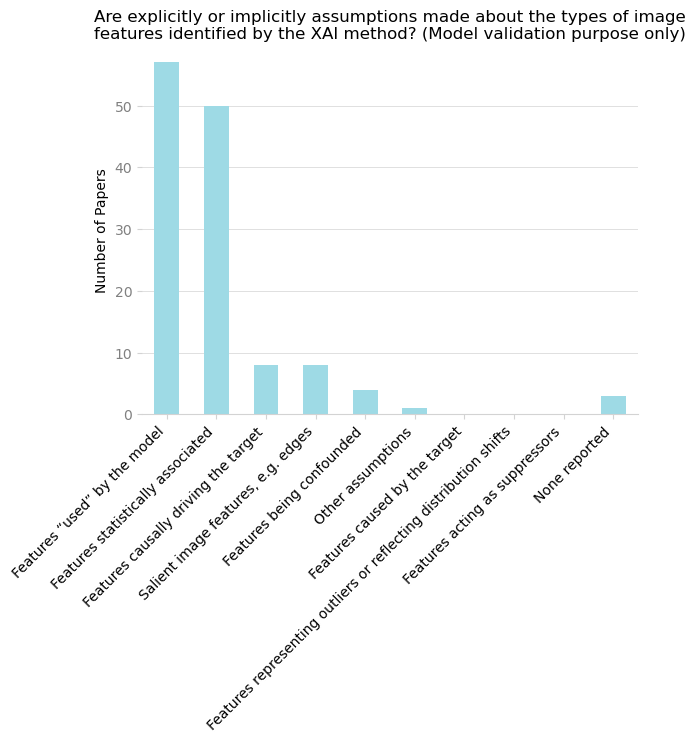

In [25]:
# Only looking at papers that have model validation as purpose

column = 'Model (in)validation'

df_xai_applied_model_valid = df_xai_applied_with_dupl[
    (df_xai_applied_with_dupl[column] != 'NR') &
    (df_xai_applied_with_dupl[column] != 'N/A') &
    (~df_xai_applied_with_dupl[column].isna())
]

# E2 Feature assumptions
title = 'Are explicitly or implicitly assumptions made about the types of image features identified by the XAI method?'

valid_counts = {}
for column in columns_feature_assumptions:
      valid_counts[column] = df_xai_applied_model_valid[column][(df_xai_applied_model_valid[column] != 'NR') & (df_xai_applied_model_valid[column] != 'N/A') & (~df_xai_applied_model_valid[column].isna())].count()

# Erstelle den Balkenplot
valid_counts_df = pd.Series(valid_counts).sort_values(ascending=False)

both_nr_count = ((df_xai_applied_model_valid[title] == "NR")).sum()
valid_counts_df["None reported"] = both_nr_count

create_frequency_bar_plot(title + " (Model validation purpose only)", valid_counts_df)

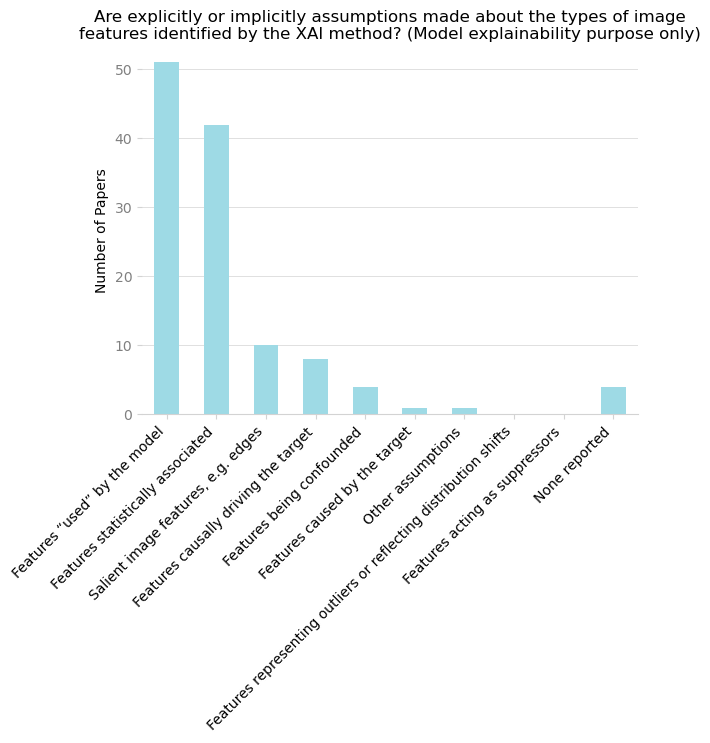

In [26]:
# Only looking at papers that have model validation as purpose

column = 'Vague explainability claims'    

df_xai_applied_explainPurpose = df_xai_applied_with_dupl[
    (df_xai_applied_with_dupl[column] != 'NR') &
    (df_xai_applied_with_dupl[column] != 'N/A') &
    (~df_xai_applied_with_dupl[column].isna())
]


# E2 Feature assumptions
title = 'Are explicitly or implicitly assumptions made about the types of image features identified by the XAI method?'

valid_counts = {}
for column in columns_feature_assumptions:
      valid_counts[column] = df_xai_applied_explainPurpose[column][(df_xai_applied_explainPurpose[column] != 'NR') & (df_xai_applied_explainPurpose[column] != 'N/A') & (~df_xai_applied_explainPurpose[column].isna())].count()

# Erstelle den Balkenplot
valid_counts_df = pd.Series(valid_counts).sort_values(ascending=False)

both_nr_count = ((df_xai_applied_explainPurpose[title] == "NR")).sum()
valid_counts_df["None reported"] = both_nr_count

create_frequency_bar_plot(title + " (Model explainability purpose only)", valid_counts_df)

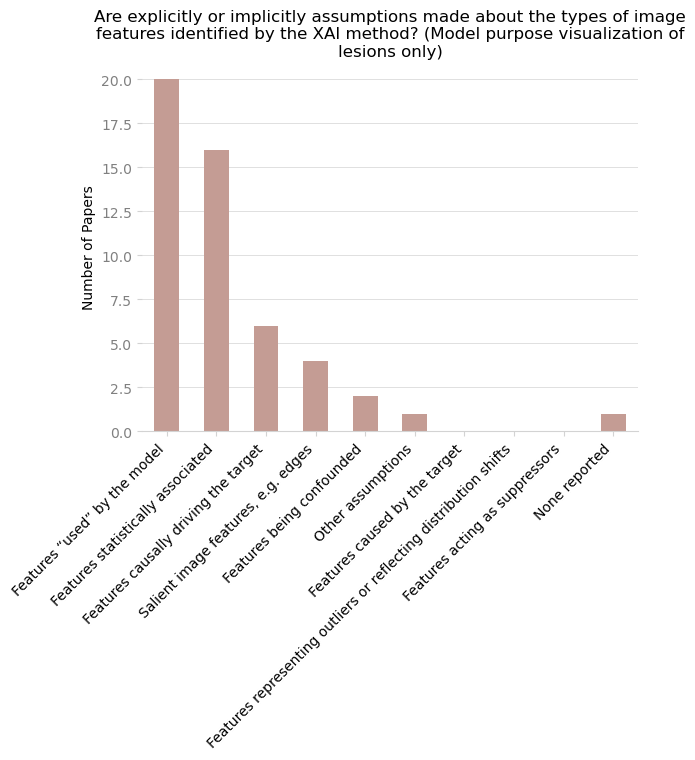

In [ ]:
# Only looking at papers that have model validation as purpose

column = 'Visually localizing lesions as part of the final tool'
    

df_xai_applied_visLes = df_xai_applied_with_dupl[
    (df_xai_applied_with_dupl[column] != 'NR') &
    (df_xai_applied_with_dupl[column] != 'N/A') &
    (~df_xai_applied_with_dupl[column].isna())
]


# E2 Feature assumptions
title = 'Are explicitly or implicitly assumptions made about the types of image features identified by the XAI method?'

valid_counts = {}
for column in columns_feature_assumptions:
      valid_counts[column] = df_xai_applied_visLes[column][(df_xai_applied_visLes[column] != 'NR') & (df_xai_applied_visLes[column] != 'N/A') & (~df_xai_applied_visLes[column].isna())].count()
 c
# Erstelle den Balkenplot
valid_counts_df = pd.Series(valid_counts).sort_values(ascending=False)

both_nr_count = ((df_xai_applied_visLes[title] == "NR")).sum()
valid_counts_df["None reported"] = both_nr_count

create_frequency_bar_plot(title + " (Model purpose visualization of lesions only)", valid_counts_df)